# <center>Data Exploratory and Preparatory Notebook on the OWID COVID-19 Dataset</center>
<hr>

## <center>1. Reader's guide 📝</center>
<hr>
This section aims to elaborate on the data we will be handling as well as the end goal of the notebook.

### 1.1 Introduction
<br>
This notebook servers as an Exploratory Data Analysis (EDA) on the data provided by <a href="https://ourworldindata.org/">OWID</a> (Our World in Data). This data contains the information about the COVID-19 pandemic for every day for all the countries that recorded data. We will be primarily looking into <b>The Netherlands</b>.

### 1.2 Goal of the document
<br>
The primary question we are trying to answer is whether the current measures, together with the vaccination trends prove sufficient for dealing with the COVID-19 pandemic in The Netherlands. Our baseline for success will be the measures taken, combined with data about hospitalizations (severe to deadly cases), vaccination efforts, and recorded cases of infection.
<br>
<br>
The goal of this notebook is to explore and visualize trends in the data as well as what it provides. This notebook also acts as a preparation notebook for time-series modelling.

## <center>2. Loading the data 🔎</center>
***  
This section aims to thoroughly research and reshape the data where needed.

### 2.1 Loading the data and importing the libraries 🧪

Firstly, we will import the libraries required for the task of data wrangling and visualization.

In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import datetime
from datetime import date

np.random.seed(21)

Next we load in and inspect the shape of the data.

In [2]:
df = pd.read_csv('./data/covid-data.csv')

Now we will create a new `DataFrame` object that contains only the features we are currently interested in. Those are the confirmed cases, vaccination efforts, hospitalizations, deaths, testing, and most importantly, strictness of the measures. We will be working with data for _The Netherlands_.

In [3]:
df_n = df[['date', 'location', 'total_cases', 'people_vaccinated', 'people_fully_vaccinated', 'hosp_patients','total_deaths' , 'total_tests', 'stringency_index']].copy()
df_n = df_n[df_n['location'] == 'Netherlands']
df_n.head(10)

,date,location,total_cases,people_vaccinated,people_fully_vaccinated,hosp_patients,total_deaths,total_tests,stringency_index
53399,2020-02-27,Netherlands,1.0,NaN,NaN,1.0,NaN,NaN,5.56
53400,2020-02-28,Netherlands,1.0,NaN,NaN,9.0,NaN,NaN,5.56
53401,2020-02-29,Netherlands,6.0,NaN,NaN,10.0,NaN,NaN,5.56
53402,2020-03-01,Netherlands,10.0,NaN,NaN,20.0,NaN,NaN,5.56
53403,2020-03-02,Netherlands,18.0,NaN,NaN,34.0,NaN,NaN,5.56
53404,2020-03-03,Netherlands,24.0,NaN,NaN,40.0,NaN,NaN,5.56
53405,2020-03-04,Netherlands,38.0,NaN,NaN,53.0,NaN,NaN,5.56
53406,2020-03-05,Netherlands,82.0,NaN,NaN,65.0,NaN,NaN,5.56
53407,2020-03-06,Netherlands,128.0,NaN,NaN,77.0,1.0,NaN,11.11
53408,2020-03-07,Netherlands,188.0,NaN,NaN,93.0,1.0,NaN,11.11


We will also parse the `date` column since this is a time-series problem.

In [4]:
df_n['date'] = pd.to_datetime(df_n['date'])

In [5]:
# Remove old rows
df_n = df_n[df_n['total_cases'].notna() & df_n['stringency_index'].notna()].reset_index(drop=True)
df_n.head(10)

,date,location,total_cases,people_vaccinated,people_fully_vaccinated,hosp_patients,total_deaths,total_tests,stringency_index
0,2020-02-27,Netherlands,1.0,NaN,NaN,1.0,NaN,NaN,5.56
1,2020-02-28,Netherlands,1.0,NaN,NaN,9.0,NaN,NaN,5.56
2,2020-02-29,Netherlands,6.0,NaN,NaN,10.0,NaN,NaN,5.56
3,2020-03-01,Netherlands,10.0,NaN,NaN,20.0,NaN,NaN,5.56
4,2020-03-02,Netherlands,18.0,NaN,NaN,34.0,NaN,NaN,5.56
5,2020-03-03,Netherlands,24.0,NaN,NaN,40.0,NaN,NaN,5.56
6,2020-03-04,Netherlands,38.0,NaN,NaN,53.0,NaN,NaN,5.56
7,2020-03-05,Netherlands,82.0,NaN,NaN,65.0,NaN,NaN,5.56
8,2020-03-06,Netherlands,128.0,NaN,NaN,77.0,1.0,NaN,11.11
9,2020-03-07,Netherlands,188.0,NaN,NaN,93.0,1.0,NaN,11.11


Next, we will separate the target variable from the features.

In [6]:
# Remove continents and extra from location
# df_n = df_n[~df_n['location'].isin(['Africa', 'North America', 'Europe', 'World', 'Asia', 'Antarctica', 'South America', 'Oceania'])]

# Assign targets
targets = ['stringency_index']

# Assign features
features = [f for f in df_n.columns if f not in targets]

## <center>3. Data visualization 📈</center>
<hr>
This section aims to visualize the features and get an initial understanding of what we are working with.

Features:
<br>
* `people_vaccinated` indicates the number of people who received at least first vaccination dose
* `people_fully_vaccinated` indicates the number of people who received the full vaccination dose 
* `hosp_patients` indicates the number of hospitalized people in a given day
* `total_deaths` indicates the number of deaths due to COVID-19
* `total_tests` indicates the number of tests for COVID-19
* `total_cases` indicates the number of confirmed cases

Targets:
<br>
* `stringency_index` indicates the government response. This index is a composite measure based on the 9 response indicators including school closure, workplace closure, travel bans, etc. The value is rescaled from 0 to 100 with 0 being the lightest and 100 being the strictest measures.

In [7]:
df_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     421 non-null    datetime64[ns]
 1   location                 421 non-null    object        
 2   total_cases              421 non-null    float64       
 3   people_vaccinated        14 non-null     float64       
 4   people_fully_vaccinated  12 non-null     float64       
 5   hosp_patients            416 non-null    float64       
 6   total_deaths             413 non-null    float64       
 7   total_tests              58 non-null     float64       
 8   stringency_index         421 non-null    float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 29.7+ KB


Our data consists of __9 columns__ and __417 rows__.  
***  
Now we can visualize the features and see how our data looks like.

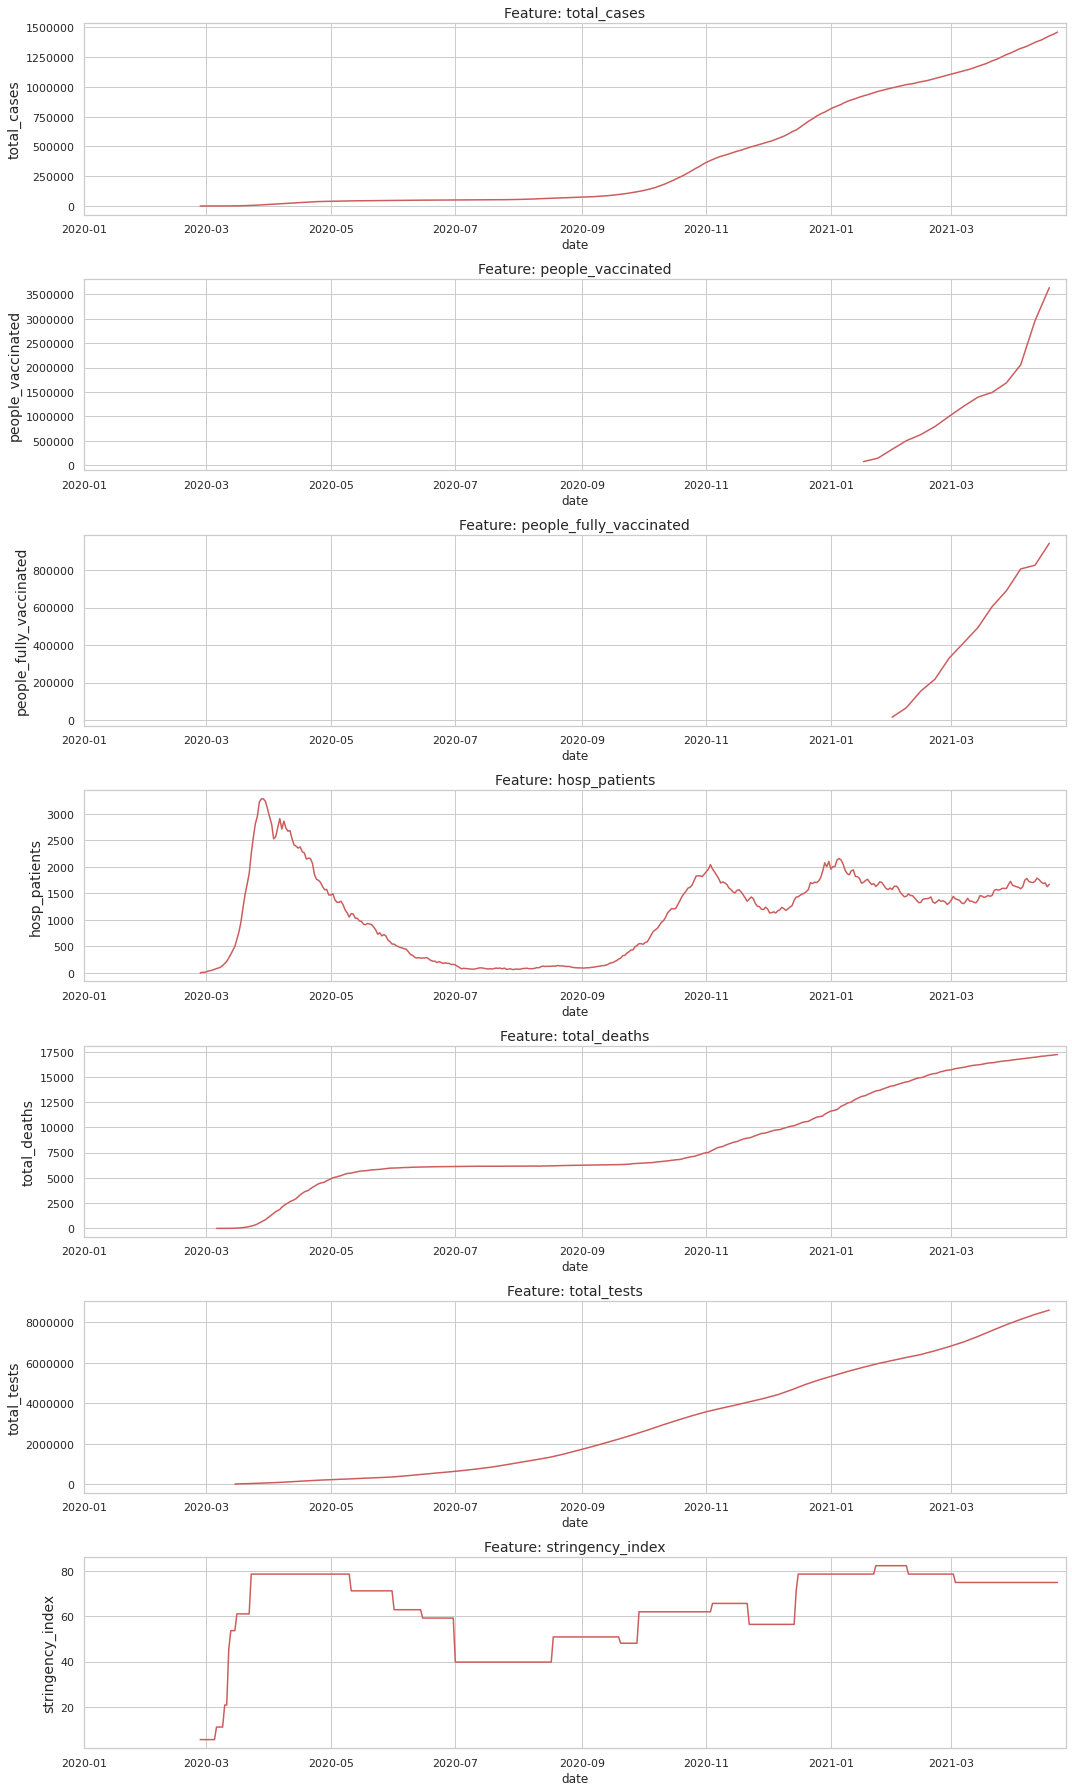

In [8]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))

for i, column in enumerate(df_n.drop(['date', 'location'], axis=1).columns):
    sns.lineplot(x=df_n['date'], y=df_n[column], ax=ax[i], color='indianred')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].ticklabel_format(style='plain', axis='y')
    
    ax[i].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])

fig.tight_layout()

As observed, all our data begins from the start of _March_, except for vaccinations. Now we can perform some data wrangling to make the data suitable for modelling.

## <center>4. Data Preprocessing 🔨</center>
<hr>
This section looks into the main problems with the data and its processing for modelling. We will be looking into the span, missing values, looking for trends and smoothing the data, stationarity (for time-series modelling), and rejection of the null hypothesis (so we can prove that our data is stationary after transformations, if required). 

### Checking Chronological Order and Ensuring Equidistant Timestamps

Since we are going to work with time series, we also need to make sure that the data is in chronological order and the timestamps are equidistant. The former will be checked by sorting the `DataFrame` object on the `date` column. The latter indicates constant time intervals which are an integral when it comes to predicting time-series. To check this, we will look at the difference between each timestamp and when it was taken.

In [9]:
df_n = df_n.sort_values(by='date')
df_n.head()

,date,location,total_cases,people_vaccinated,people_fully_vaccinated,hosp_patients,total_deaths,total_tests,stringency_index
0,2020-02-27,Netherlands,1.0,NaN,NaN,1.0,NaN,NaN,5.56
1,2020-02-28,Netherlands,1.0,NaN,NaN,9.0,NaN,NaN,5.56
2,2020-02-29,Netherlands,6.0,NaN,NaN,10.0,NaN,NaN,5.56
3,2020-03-01,Netherlands,10.0,NaN,NaN,20.0,NaN,NaN,5.56
4,2020-03-02,Netherlands,18.0,NaN,NaN,34.0,NaN,NaN,5.56


In [10]:
df_n['delta'] = df_n['date'] - df_n['date'].shift(1)
df_n[['date', 'delta']].head()

,date,delta
0,2020-02-27,NaT
1,2020-02-28,1 days
2,2020-02-29,1 days
3,2020-03-01,1 days
4,2020-03-02,1 days


In [11]:
df_n['delta'].sum(), df_n['delta'].count()

(Timedelta('420 days 00:00:00'), 420)

The data is already structurally sound and formatted. The timestamp interval is one day and the data is in chronological order.
***

### <center> 4.1 Handling Missing Values 💔</center>

Firstly, we should look into the `DataFrame` object and inspect where do we have missing values. We will replace them with `NaN` and fill them later on.

In [12]:
df_n = df_n.drop('delta', axis=1)
df_n.isna().sum()

date                         0
location                     0
total_cases                  0
people_vaccinated          407
people_fully_vaccinated    409
hosp_patients                5
total_deaths                 8
total_tests                363
stringency_index             0
dtype: int64

Next we should look into the amount of missing values and decide how should we fill them in.

In [13]:
df_n['stringency_index'] = df_n['stringency_index'].replace(0, np.nan)
df_n['people_vaccinated'] = df_n['people_vaccinated'].replace(0, np.nan)
df_n['people_fully_vaccinated'] = df_n['people_fully_vaccinated'].replace(0, np.nan)
df_n['hosp_patients'] = df_n['hosp_patients'].replace(0, np.nan)
df_n['total_tests'] = df_n['total_tests'].replace(0, np.nan)

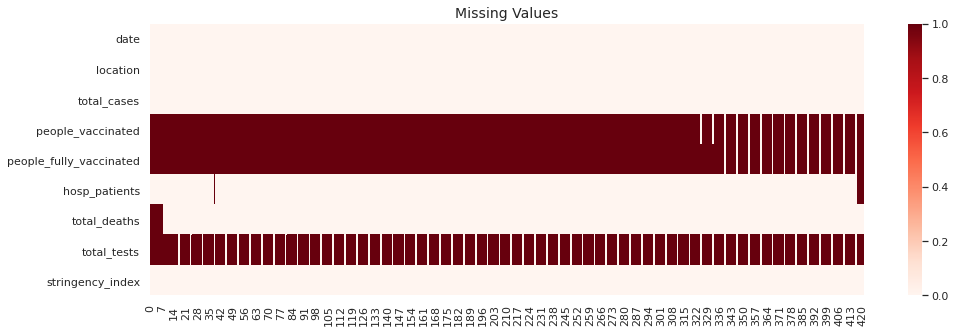

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))

sns.heatmap(df_n.T.isna(), cmap='Reds')
ax.set_title('Missing Values', fontsize=14)

plt.show()

We have a lot of missing values to deal with and we are going to explore 4 options:
* Option 1: Fill NaN with Outlier or Zero
* Option 2: Fill NaN with Mean Value
* Option 3: Fill NaN with Last Value with `.ffill()`
* Option 4: Fill NaN with Linearly Interpolated Value with `.interpolate()`

We will be exploring these options for only one feature and apply the same for the others due to the character of the missing values.

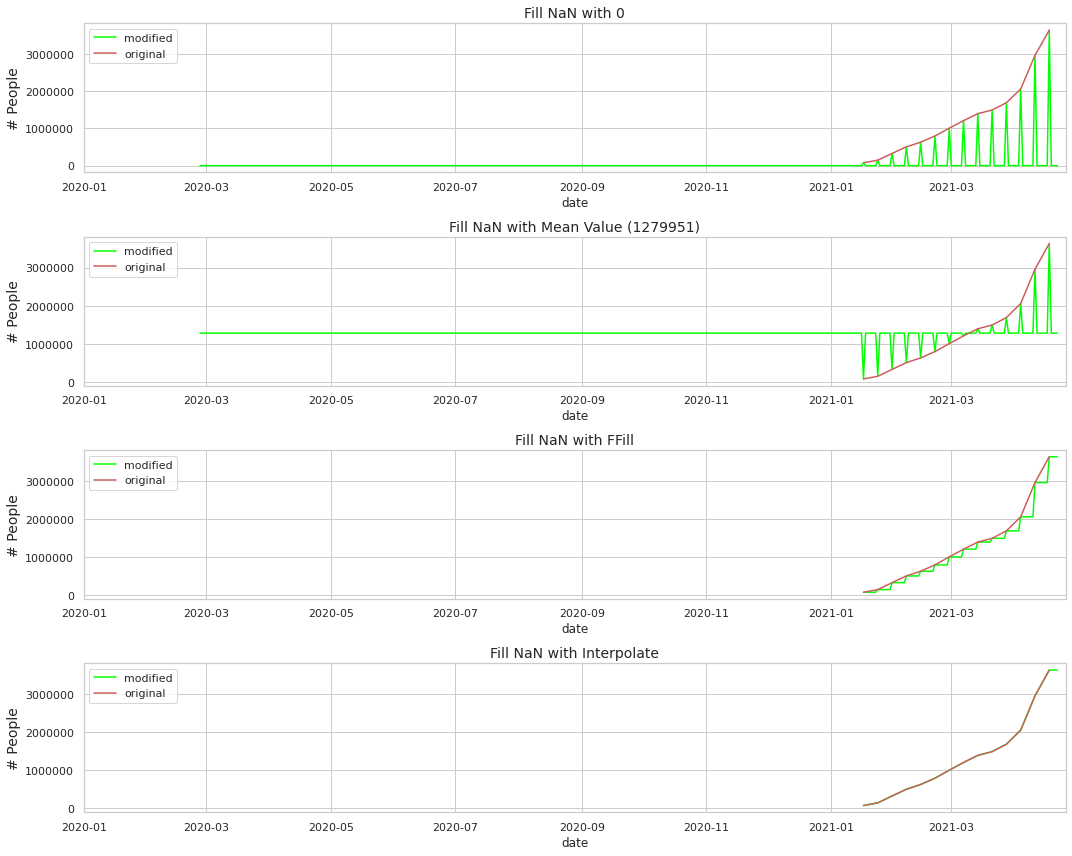

In [15]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'].fillna(0), ax=ax[0], color='lime', label = 'modified')
sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'], ax=ax[0], color='indianred', label = 'original')
ax[0].ticklabel_format(style='plain', axis='y')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='# People', fontsize=14)

mean_pv = df_n['people_vaccinated'].mean()
sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'].fillna(mean_pv), ax=ax[1], color='lime', label = 'modified')
sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'], ax=ax[1], color='indianred', label = 'original')
ax[1].ticklabel_format(style='plain', axis='y')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_pv:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='# People', fontsize=14)

sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'].ffill(), ax=ax[2], color='lime', label = 'modified')
sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'], ax=ax[2], color='indianred', label = 'original')
ax[2].ticklabel_format(style='plain', axis='y')
ax[2].set_title('Fill NaN with FFill', fontsize=14)
ax[2].set_ylabel(ylabel='# People', fontsize=14)

sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'].interpolate(), ax=ax[3], color='lime', label = 'modified')
sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'], ax=ax[3], color='indianred', label = 'original')
ax[3].ticklabel_format(style='plain', axis='y')
ax[3].set_title('Fill NaN with Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='# People', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])

fig.tight_layout()

We can also look how our missing values will look now after interpolating.

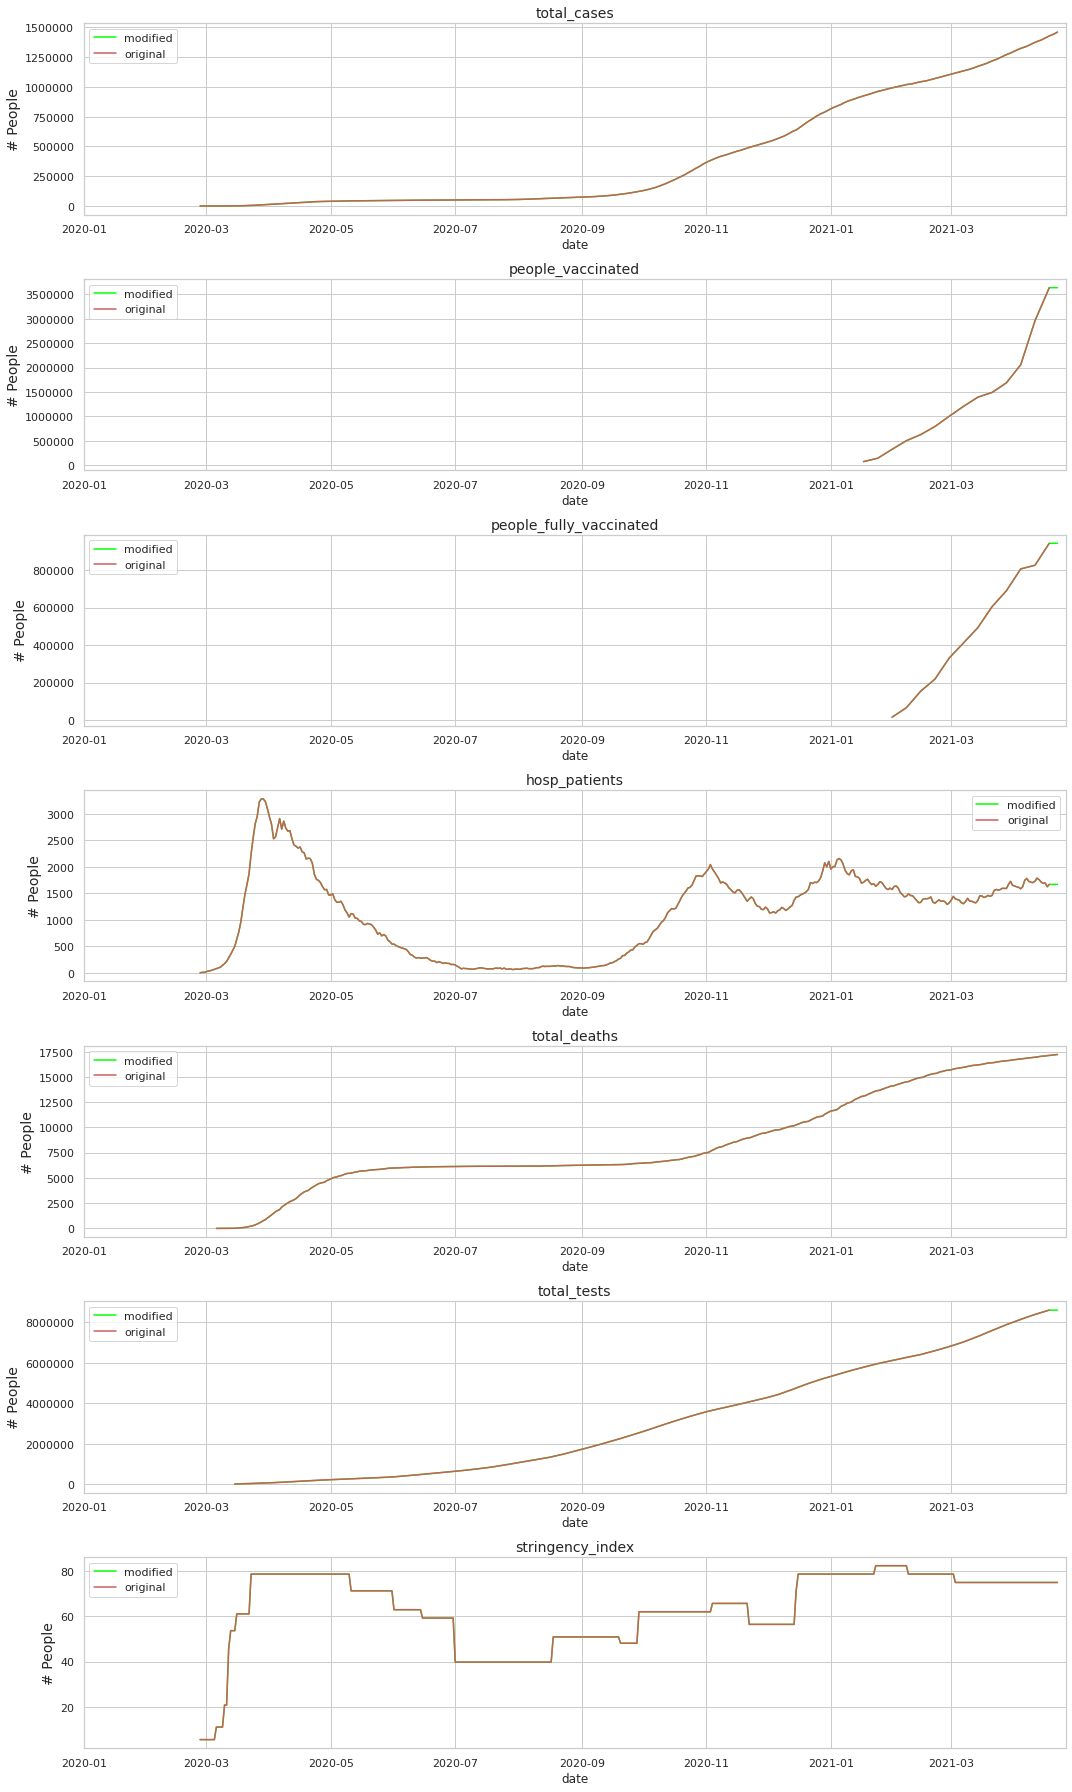

In [16]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))

for i, column in enumerate(df_n.drop(['date', 'location'], axis=1).columns):
    sns.lineplot(x=df_n['date'], y=df_n[column].interpolate(), ax=ax[i], color='lime', label = 'modified')
    sns.lineplot(x=df_n['date'], y=df_n[column], ax=ax[i], color='indianred', label = 'original')
    ax[i].ticklabel_format(style='plain', axis='y')
    ax[i].set_title('{}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel='# People', fontsize=14)
    ax[i].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])
    df_n[column].interpolate(inplace=True)
    
fig.tight_layout()

We will be using the `interpolate()` for filling since we want to patch the missing values.  
Now we need to patch the past `NaN` values and since they are non-recorded cases, filling them with `0` might be the best option.

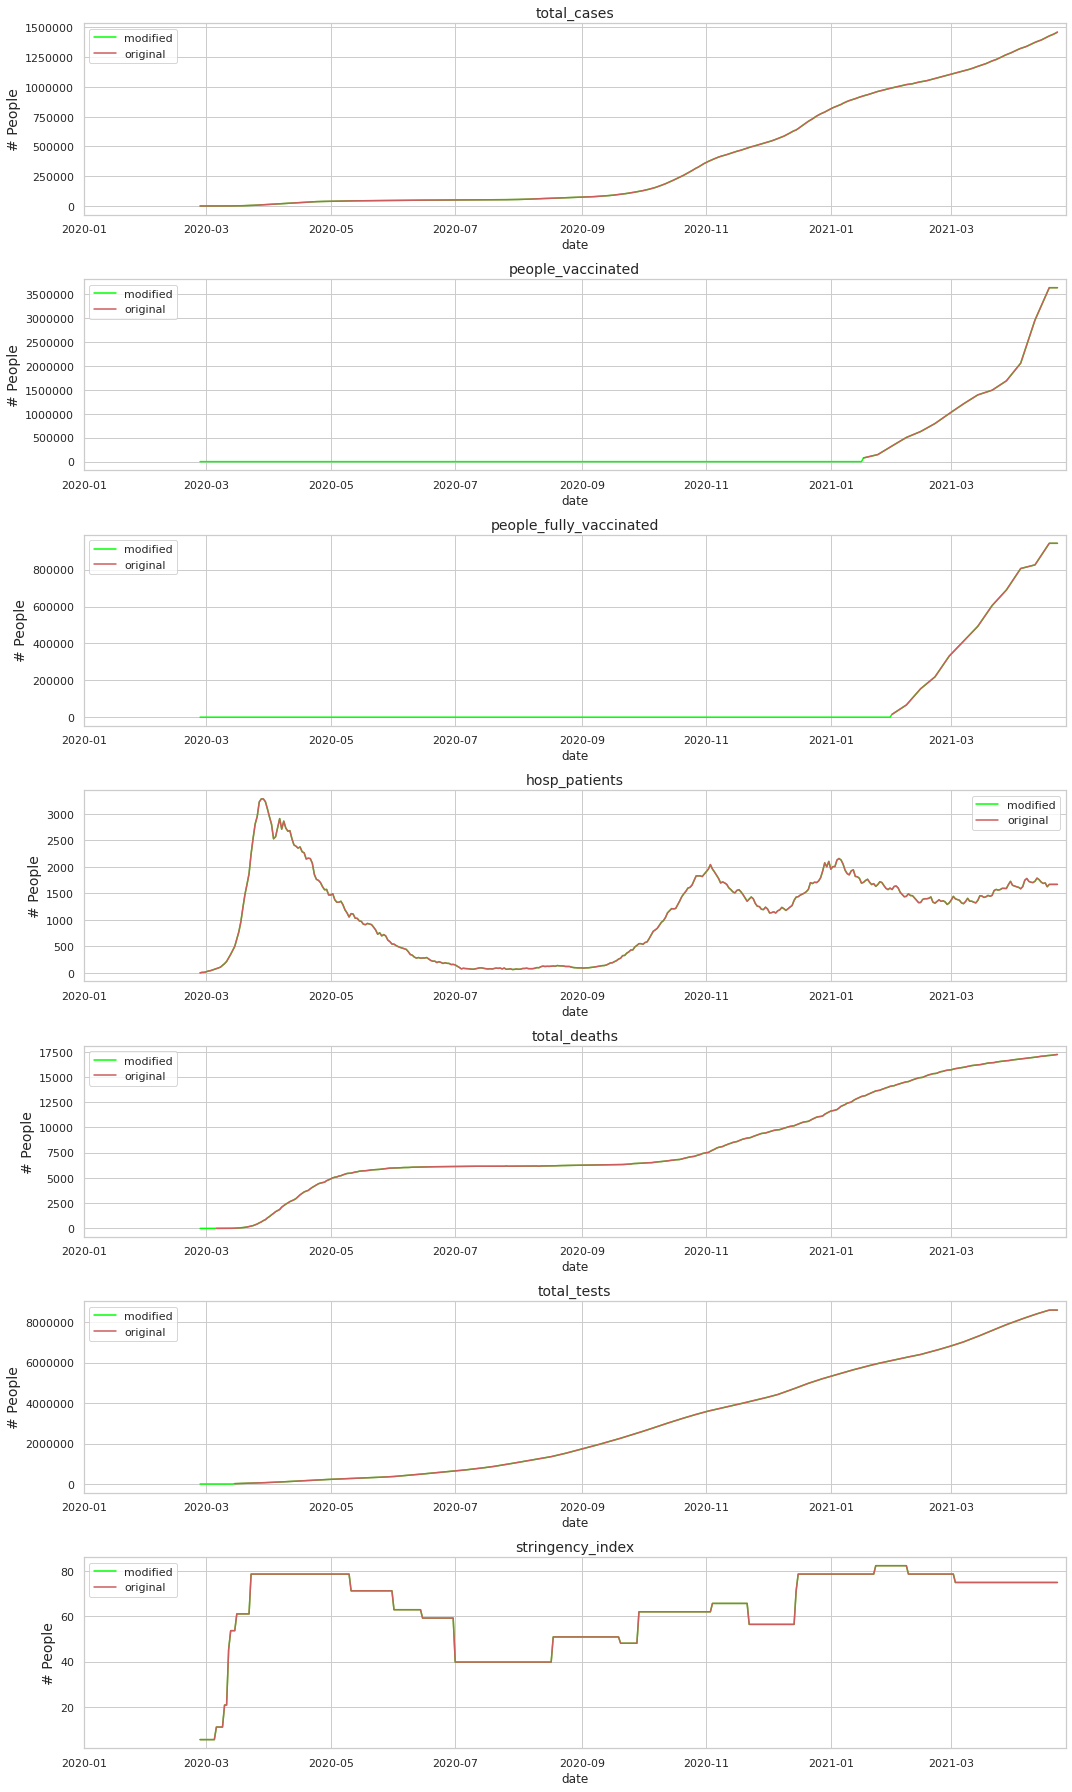

In [17]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))

for i, column in enumerate(df_n.drop(['date', 'location'], axis=1).columns):
    sns.lineplot(x=df_n['date'], y=df_n[column].fillna(0), ax=ax[i], color='lime', label = 'modified')
    sns.lineplot(x=df_n['date'], y=df_n[column], ax=ax[i], color='indianred', label = 'original')
    ax[i].ticklabel_format(style='plain', axis='y')
    ax[i].set_title('{}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel='# People', fontsize=14)
    ax[i].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])
    df_n[column].fillna(0, inplace=True)
    
fig.tight_layout()

This would help us later when modelling with _ARIMA_ and rejecting the _null hypothesis_ for the _unit root test_.

### <center>4.2 Smoothing data 🌊</center>

Next, we should try observing whether the data is too frequent or infrequent. As we have daily records it would benefit us the most to look at the bigger picture. This will be done by resampling the data. In order to achieve that we will be __downsampling__ it.

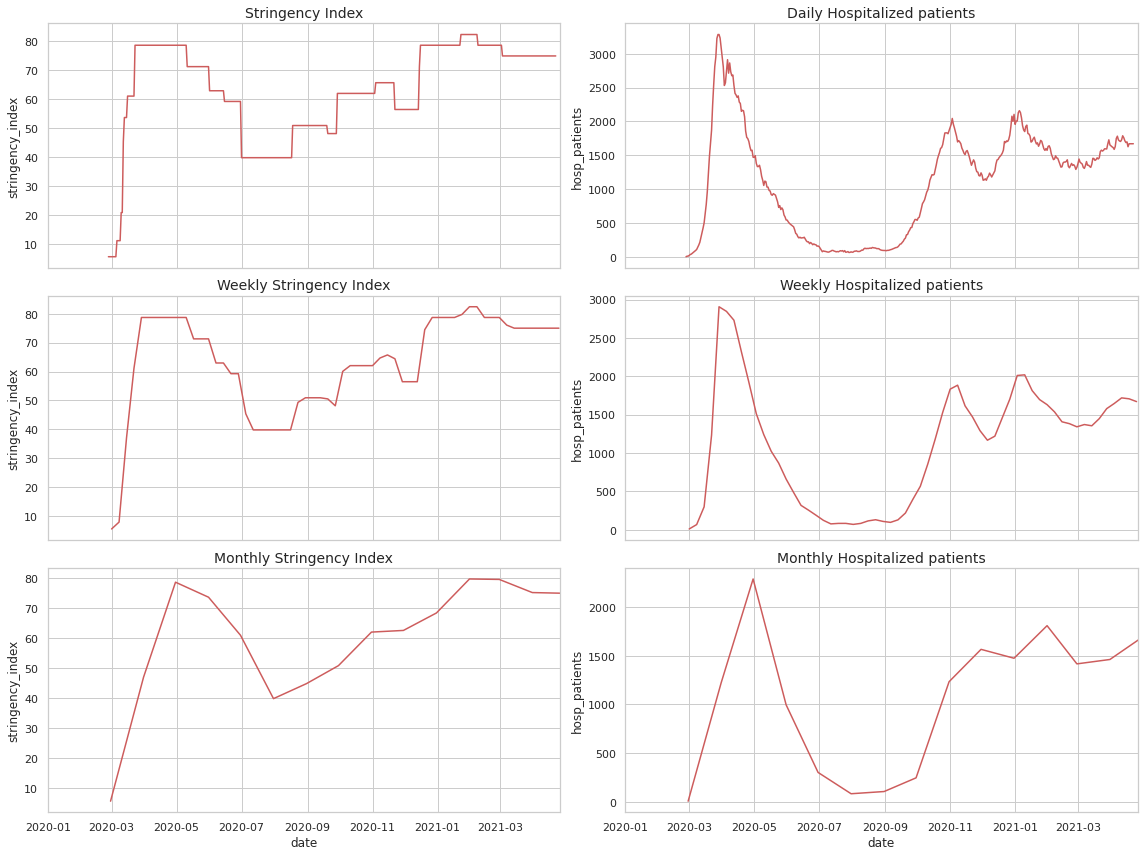

In [18]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16, 12))

# baseline data
sns.lineplot(x=df_n['date'], y=df_n['stringency_index'], color='indianred', ax=ax[0, 0])
ax[0, 0].set_title('Stringency Index', fontsize=14)
ax[0, 0].ticklabel_format(style='plain', axis='y')

# weekly is denoted by W
resampled_df_n = df_n[['date', 'stringency_index']].resample('W', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df_n['date'], y=resampled_df_n['stringency_index'], color='indianred', ax=ax[1, 0])
ax[1, 0].set_title('Weekly Stringency Index', fontsize=14)
ax[1, 0].ticklabel_format(style='plain', axis='y')

# monthly is denoted by M
resampled_df_n = df_n[['date', 'stringency_index']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df_n['date'], y=resampled_df_n['stringency_index'], color='indianred', ax=ax[2, 0])
ax[2, 0].set_title('Monthly Stringency Index', fontsize=14)
ax[2, 0].ticklabel_format(style='plain', axis='y')

for i in range(3):
    ax[i, 0].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])
    
# baseline data
sns.lineplot(x=df_n['date'], y=df_n['hosp_patients'], color='indianred', ax=ax[0, 1])
ax[0, 1].set_title('Daily Hospitalized patients', fontsize=14)

# weekly is denoted by W
resampled_df_n = df_n[['date', 'hosp_patients']].resample('W', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df_n['date'], y=resampled_df_n['hosp_patients'], color='indianred', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Hospitalized patients', fontsize=14)

# monthly is denoted by M
resampled_df_n = df_n[['date', 'hosp_patients']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df_n['date'], y=resampled_df_n['hosp_patients'], color='indianred', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Hospitalized patients', fontsize=14)

for i in range(3):
    ax[i, 1].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])
    
fig.tight_layout()

We can observe a better overview of the trends on the weekly graph. Downsampling the data to weekly could potentially smoothen the data out and help with analysis. In order to not disrupt the current trends we will be taking the mean values.

In [19]:
downsample = df_n[['date', 
                   'total_cases', 
                   'people_vaccinated', 
                   'people_fully_vaccinated', 
                   'hosp_patients', 
                   'total_deaths', 
                   'total_tests', 
                   'stringency_index']].resample('W', on='date').mean().reset_index(drop=False)

df_n = downsample.copy()

### <center>4.3 Checking Stationarity</center>

We will working with time-series models, such as _ARIMA_. These models often rely that the data supplied is stationary. So we will be looking for constant _mean_, _variance_, and _covariance_ as well as the fact that these three factors are independent of time.
<br>
<br>
To achieve our goal we will research the following:
<ul>
    <li>plot the data and check for trends or seasonality.</li> 
    <li>split the data and compare the <i>mean</i> and <i>variance</i> of each partition. </li>
    <li>a statistical test in the form of an <b>ADF</b> (Augmented Dickey Fuller). This test is used to check for seasonality.</li>
</ul>

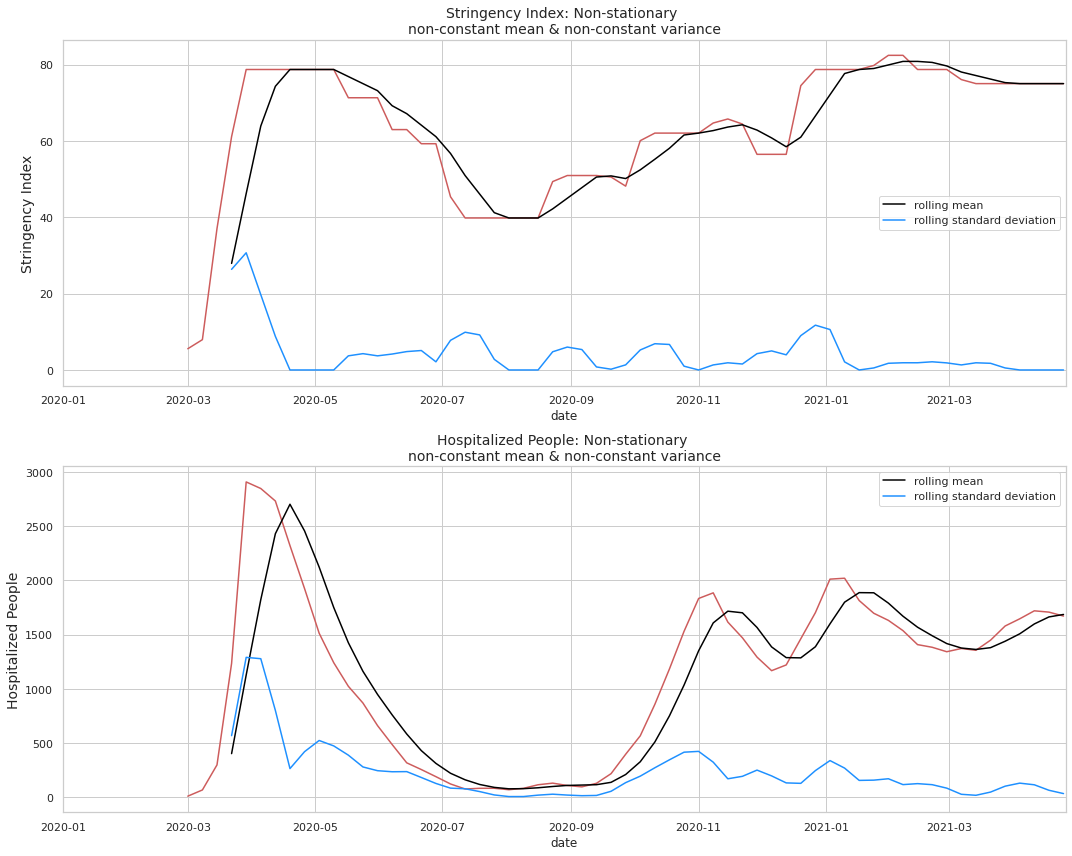

In [20]:
# 4 weeks roughly in a month, so 4 observations per partition
rolling_window = 4

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df_n['date'], y=df_n['stringency_index'], ax=ax[0], color='indianred')
sns.lineplot(x=df_n['date'], y=df_n['stringency_index'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df_n['date'], y=df_n['stringency_index'].rolling(rolling_window).std(), ax=ax[0], color='dodgerblue', label='rolling standard deviation')
ax[0].set_title('Stringency Index: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Stringency Index', fontsize=14)
ax[0].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])

sns.lineplot(x=df_n['date'], y=df_n['hosp_patients'], ax=ax[1], color='indianred')
sns.lineplot(x=df_n['date'], y=df_n['hosp_patients'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df_n['date'], y=df_n['hosp_patients'].rolling(rolling_window).std(), ax=ax[1], color='dodgerblue', label='rolling standard deviation')
ax[1].set_title('Hospitalized People: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[1].set_ylabel(ylabel='Hospitalized People', fontsize=14)
ax[1].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])

fig.tight_layout()

#### Augmented Dickey-Fuller (ADF)  
We want a time-series that has no unit root which means that the time-series is stationary. We are looking for a _p_ < _0.05(default)_. The null hypothesis could also be rejected with an _ADF statistic_ < _critical value_. (all critical values are 1%, 5%, 10%)

In [21]:
result = adfuller(df_n['stringency_index'])
result

(-4.4365102386711115,
 0.000255651242637984,
 1,
 59,
 {'1%': -3.5463945337644063,
  '5%': -2.911939409384601,
  '10%': -2.5936515282964665},
 289.27855580357107)

Now, we are going to check for each variable:  
* _p_ < 0.05  
* Check the range of the ADF statistic compared with _critical\_values_. _stats_ < _critical\_values_ (1%, 5%, 10%)

In [22]:
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']
    
    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df_n['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)
    ax.ticklabel_format(style='plain', axis='y')

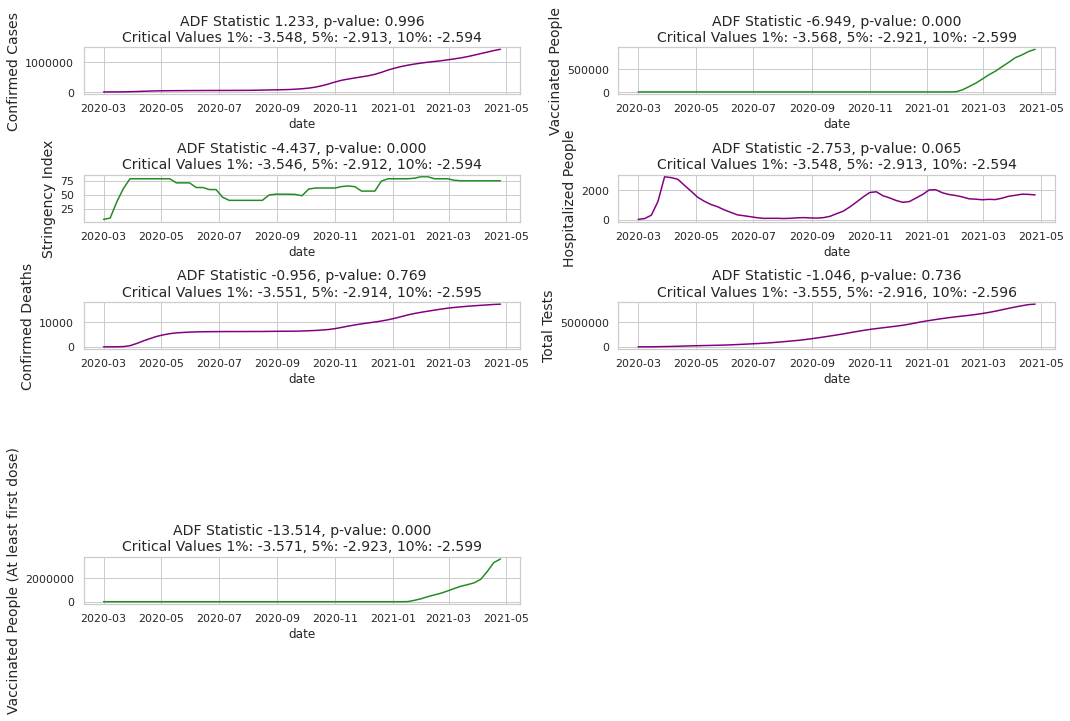

In [23]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 9))

visualize_adfuller_results(df_n['total_cases'].values, 'Confirmed Cases', ax[0, 0])
visualize_adfuller_results(df_n['people_vaccinated'].values, 'Vaccinated People (At least first dose)', ax[4, 0])
visualize_adfuller_results(df_n['people_fully_vaccinated'].values, 'Vaccinated People', ax[0, 1])
visualize_adfuller_results(df_n['hosp_patients'].values, 'Hospitalized People', ax[1, 1])
visualize_adfuller_results(df_n['total_deaths'].values, 'Confirmed Deaths', ax[2, 0])
visualize_adfuller_results(df_n['total_tests'].values, 'Total Tests', ax[2, 1])
visualize_adfuller_results(df_n['stringency_index'].values, 'Stringency Index', ax[1, 0])

fig.delaxes(ax[3, 0])
fig.delaxes(ax[3, 1])
fig.delaxes(ax[4, 1])
fig.tight_layout()

Since only three feature rejects the null hypothesis (`people_vaccinated`, `stringency_index`, `people_fully_vaccinated`), we need to transform the other from non-stationary to stationary time-series. This will be achieved by _differencing_ them as many times as needed and check by plotting them again.

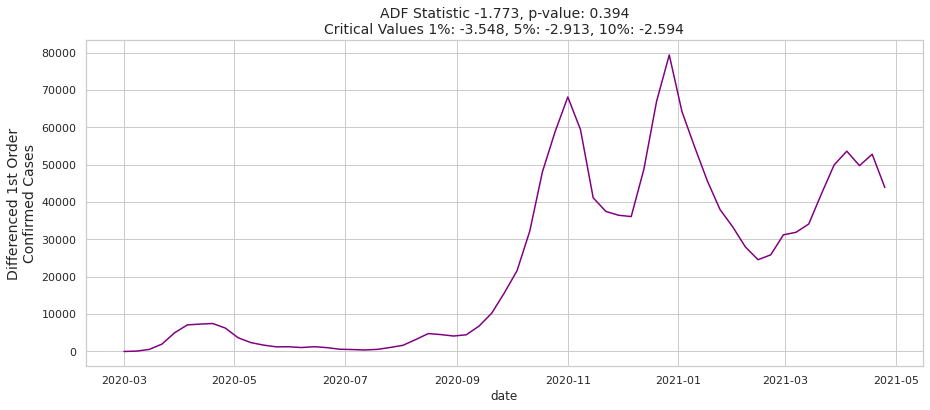

In [24]:
diff = np.diff(df_n['total_cases'])
df_n['total_cases_diff_1'] = np.append([0], diff)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df_n['total_cases_diff_1'], 'Differenced 1st Order\nConfirmed Cases', ax)

First order differencing did not solve our issue, so we need to try second-order differencing. In simple terms - difference the differenced values.

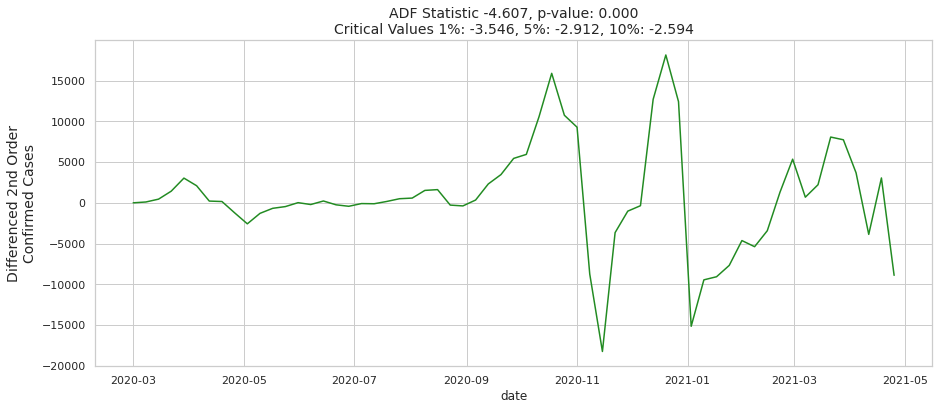

In [25]:
diff_2 = np.diff(df_n['total_cases_diff_1'])
df_n['total_cases_diff_2'] = np.append([0], diff_2)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df_n['total_cases_diff_2'], 'Differenced 2nd Order\nConfirmed Cases', ax)

As we can see, second-order differencing gave us the right result. The transformations rejected the null hypothesis, meaning our data is now stationary.  
We need to do the same for the other features as well.

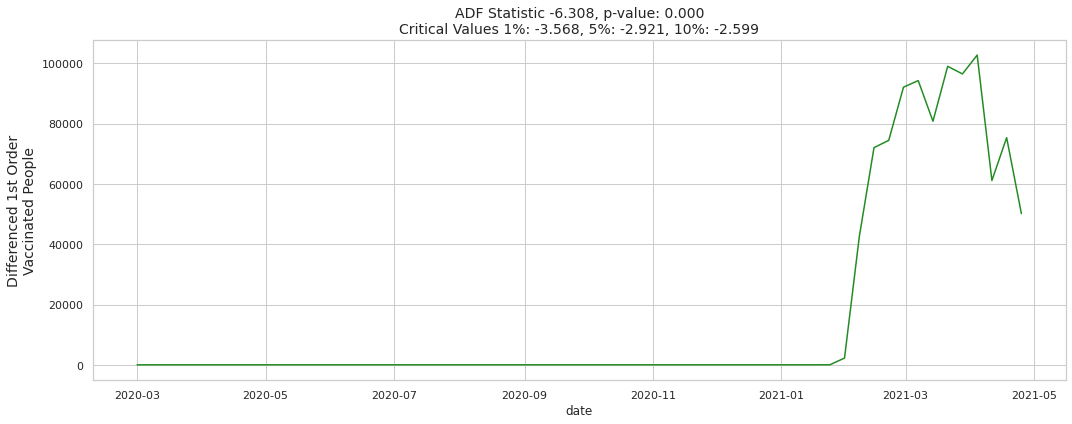

In [26]:
diff = np.diff(df_n['people_fully_vaccinated'])
df_n['people_fully_vaccinated_diff_1'] = np.append([0], diff)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df_n['people_fully_vaccinated_diff_1'], 'Differenced 1st Order\nVaccinated People', ax)

fig.tight_layout()

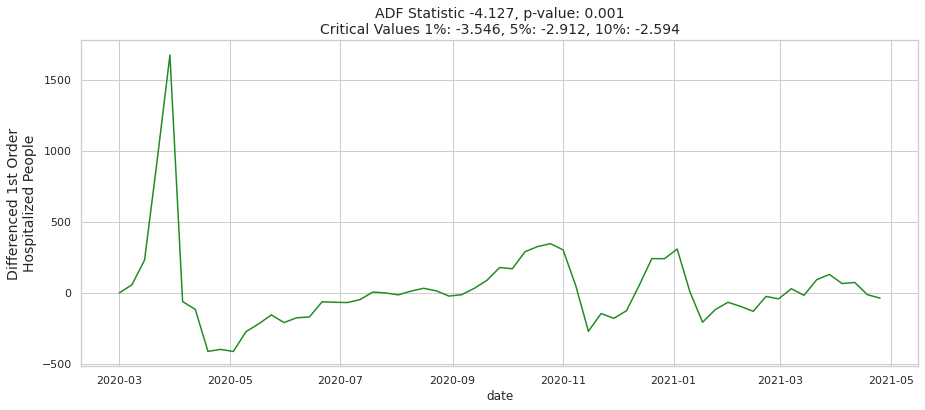

In [27]:
diff = np.diff(df_n['hosp_patients'])
df_n['hosp_patients_diff_1'] = np.append([0], diff)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df_n['hosp_patients_diff_1'], 'Differenced 1st Order\nHospitalized People', ax)

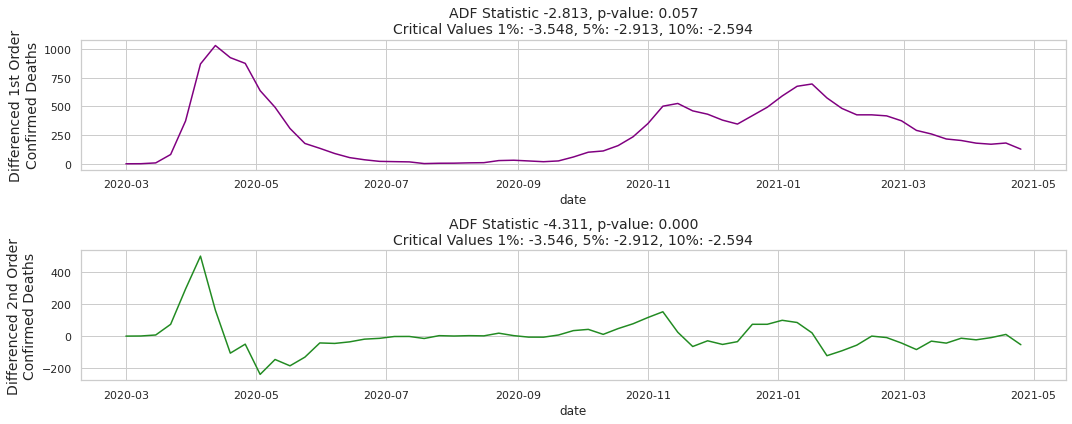

In [28]:
diff = np.diff(df_n['total_deaths'])
df_n['total_deaths_diff_1'] = np.append([0], diff)
diff2 = np.diff(df_n['total_deaths_diff_1'])
df_n['total_deaths_diff_2'] = np.append([0], diff2)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df_n['total_deaths_diff_1'], 'Differenced 1st Order\nConfirmed Deaths', ax[0])
visualize_adfuller_results(df_n['total_deaths_diff_2'], 'Differenced 2nd Order\nConfirmed Deaths', ax[1])

fig.tight_layout()

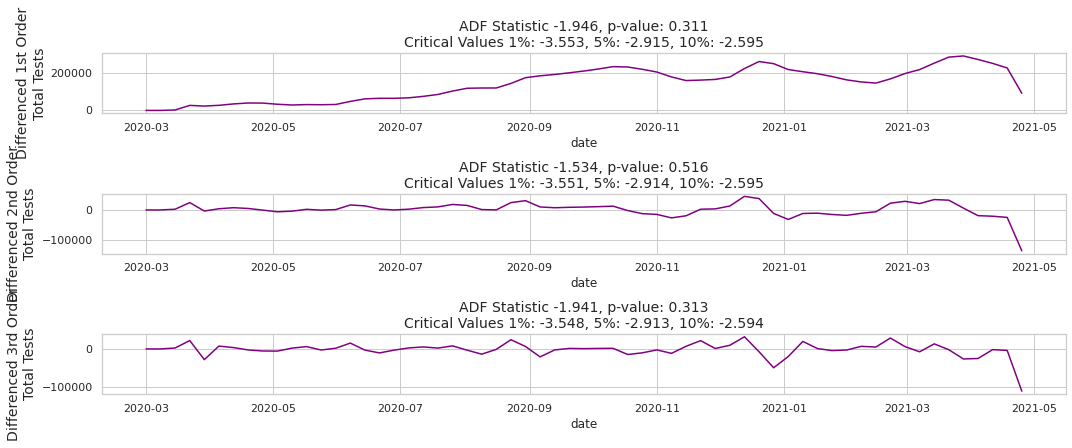

In [29]:
diff = np.diff(df_n['total_tests'])
df_n['total_tests_diff_1'] = np.append([0], diff)
diff2 = np.diff(df_n['total_tests_diff_1'])
df_n['total_tests_diff_2'] = np.append([0], diff2)
diff3 = np.diff(df_n['total_tests_diff_2'])
df_n['total_tests_diff_3'] = np.append([0], diff3)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df_n['total_tests_diff_1'], 'Differenced 1st Order\nTotal Tests', ax[0])
visualize_adfuller_results(df_n['total_tests_diff_2'], 'Differenced 2nd Order\nTotal Tests', ax[1])
visualize_adfuller_results(df_n['total_tests_diff_3'], 'Differenced 3rd Order\nTotal Tests', ax[2])

fig.tight_layout()

We have not fully stationarized this feature, but since _p-value_ < 0.05 we can give it a pass.

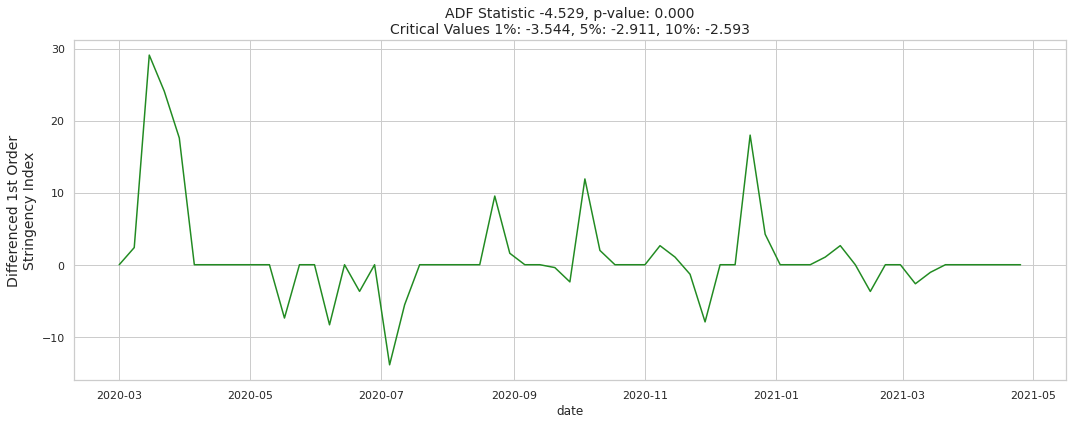

In [30]:
diff = np.diff(df_n['stringency_index'])
df_n['stringency_index_diff_1'] = np.append([0], diff)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df_n['stringency_index_diff_1'], 'Differenced 1st Order\nStringency Index', ax)

fig.tight_layout()

In [31]:
df_n['total_cases_diff'] = df_n['total_cases_diff_2']
df_n['people_fully_vaccinated_diff'] = df_n['people_fully_vaccinated_diff_1']
df_n['hosp_patients_diff'] = df_n['hosp_patients_diff_1']
df_n['total_deaths_diff'] = df_n['total_deaths_diff_2']
df_n['total_tests_diff'] = df_n['total_tests_diff_3']
df_n['stringency_index_diff'] = df_n['stringency_index_diff_1']

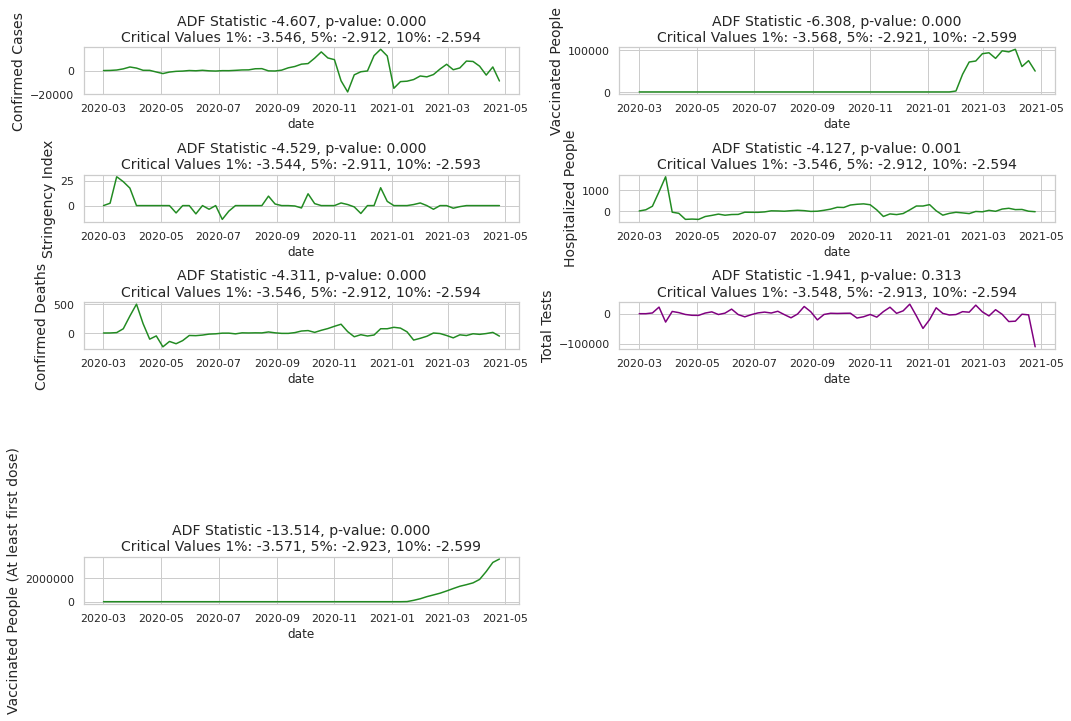

In [32]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 9))

visualize_adfuller_results(df_n['total_cases_diff'].values, 'Confirmed Cases', ax[0, 0])
visualize_adfuller_results(df_n['people_vaccinated'].values, 'Vaccinated People (At least first dose)', ax[4, 0])
visualize_adfuller_results(df_n['people_fully_vaccinated_diff'].values, 'Vaccinated People', ax[0, 1])
visualize_adfuller_results(df_n['hosp_patients_diff'].values, 'Hospitalized People', ax[1, 1])
visualize_adfuller_results(df_n['total_deaths_diff'].values, 'Confirmed Deaths', ax[2, 0])
visualize_adfuller_results(df_n['total_tests_diff'].values, 'Total Tests', ax[2, 1])
visualize_adfuller_results(df_n['stringency_index_diff'].values, 'Stringency Index', ax[1, 0])

fig.delaxes(ax[3, 0])
fig.delaxes(ax[3, 1])
fig.delaxes(ax[4, 1])
fig.tight_layout()

Now we have the _differenced_ features that pass the __ADF__ test and reject the _null hypothesis_. We will not be overriding them in the `DataFrame` object but we will keep them as a separate column to be used for further analysis.
***
Now we can continue, but firstly, we will drop the temporary columns left from the differencing.

In [33]:
df_n = df_n.drop(['total_cases_diff_1', 'total_cases_diff_2', 'total_tests_diff_3',
                  'people_fully_vaccinated_diff_1', 
                  'hosp_patients_diff_1', 'total_deaths_diff_1', 'total_deaths_diff_2',
                  'total_tests_diff_1', 'total_tests_diff_2', 'stringency_index_diff_1'], axis=1)

In [34]:
df_n.head()

,date,total_cases,people_vaccinated,people_fully_vaccinated,hosp_patients,total_deaths,total_tests,stringency_index,total_cases_diff,people_fully_vaccinated_diff,hosp_patients_diff,total_deaths_diff,total_tests_diff,stringency_index_diff
0,2020-03-01,4.500000,0.0,0.0,10.000000,0.000000,0.000000,5.560000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,2020-03-08,106.142857,0.0,0.0,67.142857,0.714286,0.000000,7.938571,101.642857,0.0,57.142857,0.714286,0.000000,2.378571
2,2020-03-15,659.285714,0.0,0.0,298.142857,8.428571,2440.000000,37.034286,451.500000,0.0,231.000000,7.000000,2440.000000,29.095714
3,2020-03-22,2644.571429,0.0,0.0,1233.571429,89.428571,29273.142857,61.110000,1432.142857,0.0,935.428571,73.285714,21953.142857,24.075714
4,2020-03-29,7663.714286,0.0,0.0,2906.428571,463.142857,52558.000000,78.700000,3033.857143,0.0,1672.857143,292.714286,-27941.428571,17.590000


Now this is satisfactory for later modelling. We have rejected the null hypothesis on all our features.
***

## <center>5. Feature Engineering 🔧</center>
<hr>
In this section we will be looking into the features and their decomposition. We will also be looking into the shifted (lagged) values for the time-series decomposition.
<br>

Now we need to get a generally better understanding of our data for forecasting. This is why why will be using __time-series decomposition__. This way we will think about the series as a combination of level, trend, seasonality, and noise. It is useful to __decompose__ the data so we can examine how the changes with a chosen data point compare to shifts in the other variables over the same time period. This is the legend of the things we are looking for:  
* __Level__: The average value of the series  
* __Trend__: The increasing or decreasing value of the series  
* __Seasonality__: The repeating short-term cycles in the series  
* __Noise__: The random variation in the series

There are also two ways of thinking about the components - as combining them either _additively_ or _multiplicatively_. This thinking will depend on two characteristics:  
* If the seasonality and the residual components are independent of the trend - __additive__
* If the seasonality and the residual components are dependent on the trend - __multiplicative__

In addition __multiplicative__ decomposition is not suited for negative or 0 values and in our case, we do have plenty of those, so the model we are going to use is __additive__.

In [35]:
core_columns = [
    'total_cases', 'people_vaccinated', 
    'people_fully_vaccinated', 'hosp_patients', 
    'total_deaths', 'total_tests', 'stringency_index']

for column in core_columns:
    decomp_n = seasonal_decompose(df_n[column], period=4, model='additive', extrapolate_trend='freq')
    
    df_n[f"{column}_trend"] = decomp_n.trend
    df_n[f"{column}_seasonal"] = decomp_n.seasonal

<ipython-input-36-1d4626a7788a>:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  res = seasonal_decompose(df_n[column], freq=4, model='additive', extrapolate_trend='freq')
<ipython-input-36-1d4626a7788a>:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  res = seasonal_decompose(df_n[column], freq=4, model='additive', extrapolate_trend='freq')


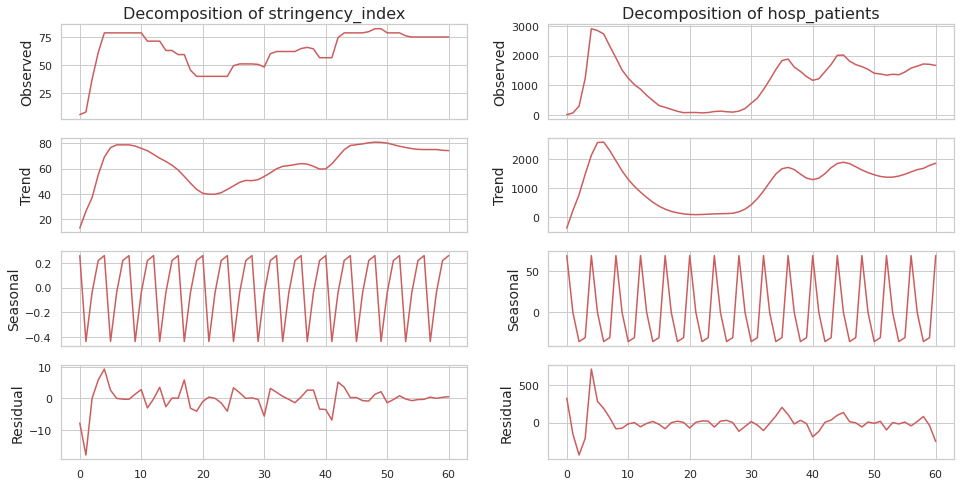

In [36]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['stringency_index', 'hosp_patients']):
    
    res = seasonal_decompose(df_n[column], freq=4, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='indianred')
    ax[0,i].set_ylabel('Observed', fontsize=14)
    ax[0,i].ticklabel_format(style='plain', axis='y')

    res.trend.plot(ax=ax[1,i], legend=False, color='indianred')
    ax[1,i].set_ylabel('Trend', fontsize=14)
    ax[1,i].ticklabel_format(style='plain', axis='y')

    res.seasonal.plot(ax=ax[2,i], legend=False, color='indianred')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    ax[2,i].ticklabel_format(style='plain', axis='y')
    
    res.resid.plot(ax=ax[3,i], legend=False, color='indianred')
    ax[3,i].set_ylabel('Residual', fontsize=14)
    ax[3,i].ticklabel_format(style='plain', axis='y')

plt.show()

Next what we want to do is calculate the _lag_ to compare the correlation with other variables. This will be done with the `shift()` method. We will be doing this to check for seasonality by plotting a greater number of periods (_lags_). Seasonality will repeat itself periodically.

In [37]:
weeks_in_month = 4

for column in core_columns:
    df_n[f'{column}_seasonal_shift_b_2m'] = df_n[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df_n[f'{column}_seasonal_shift_b_1m'] = df_n[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df_n[f'{column}_seasonal_shift_1m'] = df_n[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df_n[f'{column}_seasonal_shift_2m'] = df_n[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df_n[f'{column}_seasonal_shift_3m'] = df_n[f'{column}_seasonal'].shift(3 * weeks_in_month)

Now we can check how our data looks like.

In [38]:
df_n.head()

,date,total_cases,people_vaccinated,people_fully_vaccinated,hosp_patients,total_deaths,total_tests,stringency_index,total_cases_diff,people_fully_vaccinated_diff,hosp_patients_diff,total_deaths_diff,total_tests_diff,stringency_index_diff,total_cases_trend,total_cases_seasonal,people_vaccinated_trend,people_vaccinated_seasonal,people_fully_vaccinated_trend,people_fully_vaccinated_seasonal,hosp_patients_trend,hosp_patients_seasonal,total_deaths_trend,total_deaths_seasonal,total_tests_trend,total_tests_seasonal,stringency_index_trend,stringency_index_seasonal,total_cases_seasonal_shift_b_2m,total_cases_seasonal_shift_b_1m,total_cases_seasonal_shift_1m,total_cases_seasonal_shift_2m,total_cases_seasonal_shift_3m,people_vaccinated_seasonal_shift_b_2m,people_vaccinated_seasonal_shift_b_1m,people_vaccinated_seasonal_shift_1m,people_vaccinated_seasonal_shift_2m,people_vaccinated_seasonal_shift_3m,people_fully_vaccinated_seasonal_shift_b_2m,people_fully_vaccinated_seasonal_shift_b_1m,people_fully_vaccinated_seasonal_shift_1m,people_fully_vaccinated_seasonal_shift_2m,people_fully_vaccinated_seasonal_shift_3m,hosp_patients_seasonal_shift_b_2m,hosp_patients_seasonal_shift_b_1m,hosp_patients_seasonal_shift_1m,hosp_patients_seasonal_shift_2m,hosp_patients_seasonal_shift_3m,total_deaths_seasonal_shift_b_2m,total_deaths_seasonal_shift_b_1m,total_deaths_seasonal_shift_1m,total_deaths_seasonal_shift_2m,total_deaths_seasonal_shift_3m,total_tests_seasonal_shift_b_2m,total_tests_seasonal_shift_b_1m,total_tests_seasonal_shift_1m,total_tests_seasonal_shift_2m,total_tests_seasonal_shift_3m,stringency_index_seasonal_shift_b_2m,stringency_index_seasonal_shift_b_1m,stringency_index_seasonal_shift_1m,stringency_index_seasonal_shift_2m,stringency_index_seasonal_shift_3m
0,2020-03-01,4.500000,0.0,0.0,10.000000,0.000000,0.000000,5.560000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-7931.941964,988.445191,0.0,21460.378689,0.0,-3426.279433,-386.675000,69.444092,-955.962500,25.144118,-35745.601786,-8396.889187,13.083286,0.259736,988.445191,988.445191,NaN,NaN,NaN,21460.378689,21460.378689,NaN,NaN,NaN,-3426.279433,-3426.279433,NaN,NaN,NaN,69.444092,69.444092,NaN,NaN,NaN,25.144118,25.144118,NaN,NaN,NaN,-8396.889187,-8396.889187,NaN,NaN,NaN,0.259736,0.259736,NaN,NaN,NaN
1,2020-03-08,106.142857,0.0,0.0,67.142857,0.714286,0.000000,7.938571,101.642857,0.0,57.142857,0.714286,0.000000,2.378571,-3472.616071,-494.241175,0.0,-29927.604682,0.0,2577.078343,218.651786,-0.834777,-495.589286,13.506544,-12303.303571,2690.094332,26.323036,-0.438511,-494.241175,-494.241175,NaN,NaN,NaN,-29927.604682,-29927.604682,NaN,NaN,NaN,2577.078343,2577.078343,NaN,NaN,NaN,-0.834777,-0.834777,NaN,NaN,NaN,13.506544,13.506544,NaN,NaN,NaN,2690.094332,2690.094332,NaN,NaN,NaN,-0.438511,-0.438511,NaN,NaN,NaN
2,2020-03-15,659.285714,0.0,0.0,298.142857,8.428571,2440.000000,37.034286,451.500000,0.0,231.000000,7.000000,2440.000000,29.095714,1811.026786,-1124.247722,0.0,-19818.723730,0.0,1539.673581,764.267857,-36.722277,82.535714,-12.082444,14498.035714,4092.753856,37.053214,-0.040964,-1124.247722,-1124.247722,NaN,NaN,NaN,-19818.723730,-19818.723730,NaN,NaN,NaN,1539.673581,1539.673581,NaN,NaN,NaN,-36.722277,-36.722277,NaN,NaN,NaN,-12.082444,-12.082444,NaN,NaN,NaN,4092.753856,4092.753856,NaN,NaN,NaN,-0.040964,-0.040964,NaN,NaN,NaN
3,2020-03-22,2644.571429,0.0,0.0,1233.571429,89.428571,29273.142857,61.110000,1432.142857,0.0,935.428571,73.285714,21953.142857,24.075714,4602.821429,630.043706,0.0,28285.949723,0.0,-690.472491,1473.660714,-31.887039,307.089286,-26.568218,31041.589286,1614.040999,55.040893,0.219739,630.043706,630.043706,NaN,NaN,NaN,28285.949723,28285.949723,NaN,NaN,NaN,-690.472491,-690.472491,NaN,NaN,NaN,-31.887039,-31.887039,NaN,NaN,NaN,-26.568218,-26.568218,NaN,NaN,NaN,1614.040999,1614.040999,NaN,NaN,NaN,0.219739,0.219739,NaN,NaN,NaN
4,2020-03-29,7663.714286,0.0,0.0,2906.428571,463.142857,52558.000000,78.700000,3033.857143,0.0,1672.857143,292.714286,-27941.428571,17.590000,9118.839286,988

We have some `NaN` values from the __shifted__ columns which we will be looking into if they cause troubles.

Now that we have cleaned up and transformed the data, we can go into an __EDA__ (Exploratory Data Analysis).
***

## <center>6. Exploratory Data Analysis 📊</center>

Now, we are going to plot and extract knowledge from our data.
<hr>
Firstly, we will make a simple <i>scatterplot</i>, which will give us a superficial look whether there is any <i>seasonality</i> in our data.

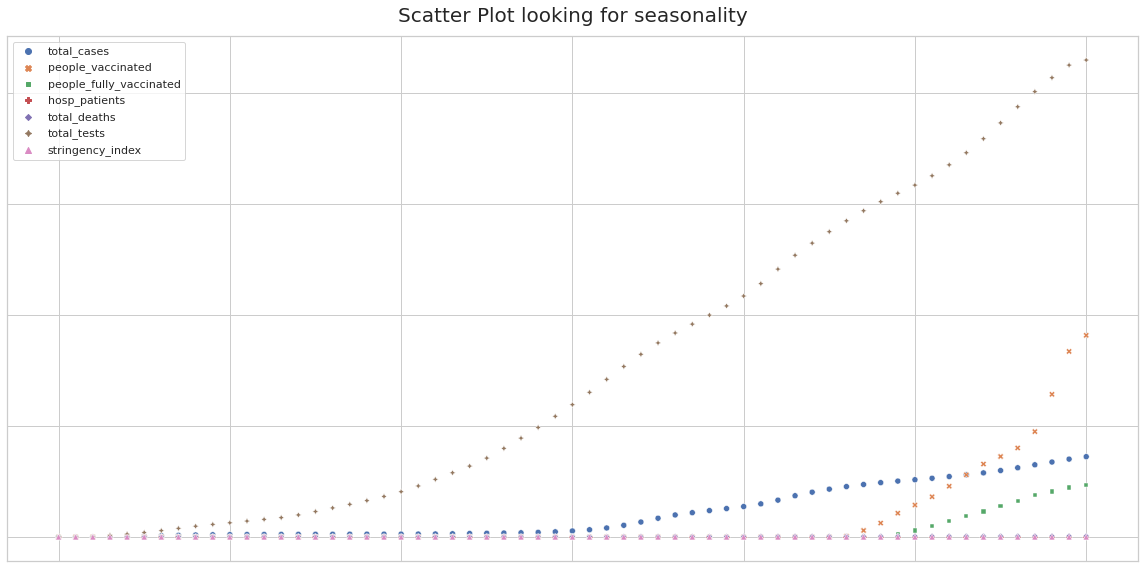

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

fig.suptitle('Scatter Plot looking for seasonality', fontsize=20)
sns.scatterplot(data=df_n[[c for c in core_columns]], ax=ax)
ax.ticklabel_format(style='plain', axis='y')
ax.set(
    yticklabels = [],
    xticklabels = []
)

fig.tight_layout()

We can see that when looking at COVID-19, there is no apparent seasonality.

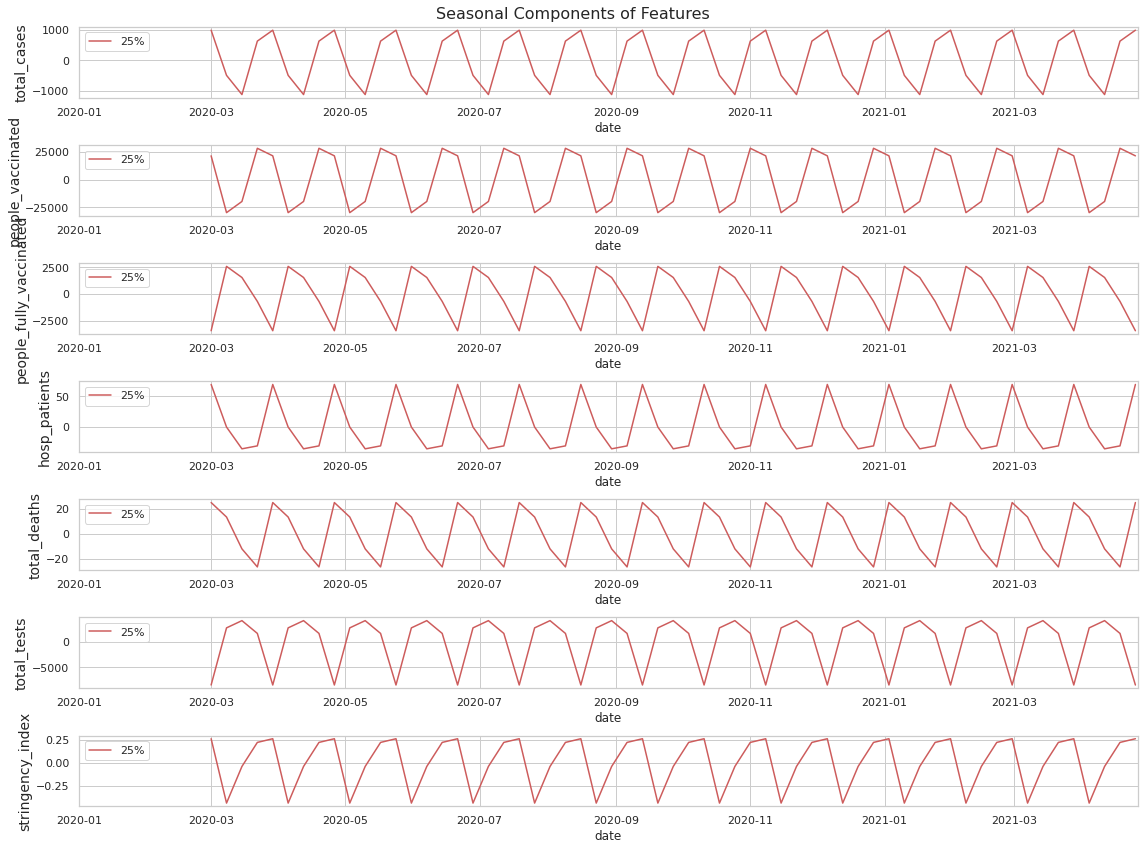

In [40]:
fig, ax = plt.subplots(nrows=len(core_columns), ncols=1, figsize=(16, 12))
fig.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df_n['date'], y=df_n[column + '_seasonal'], ax=ax[i], color='indianred', label='25%')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])
    ax[i].ticklabel_format(style='plain', axis='y')

fig.tight_layout()

As we can see COVID-19 has no seasonality and we can see no apparent trend or seasonal components from the _25th percent_ of the decomposition.  
***  
Now we can look into the _correlation_ between the original core features and the lagged core features. We are looking into the offset because the number of possible matches decreases because the series "hang out" at the ends and do not overlap.

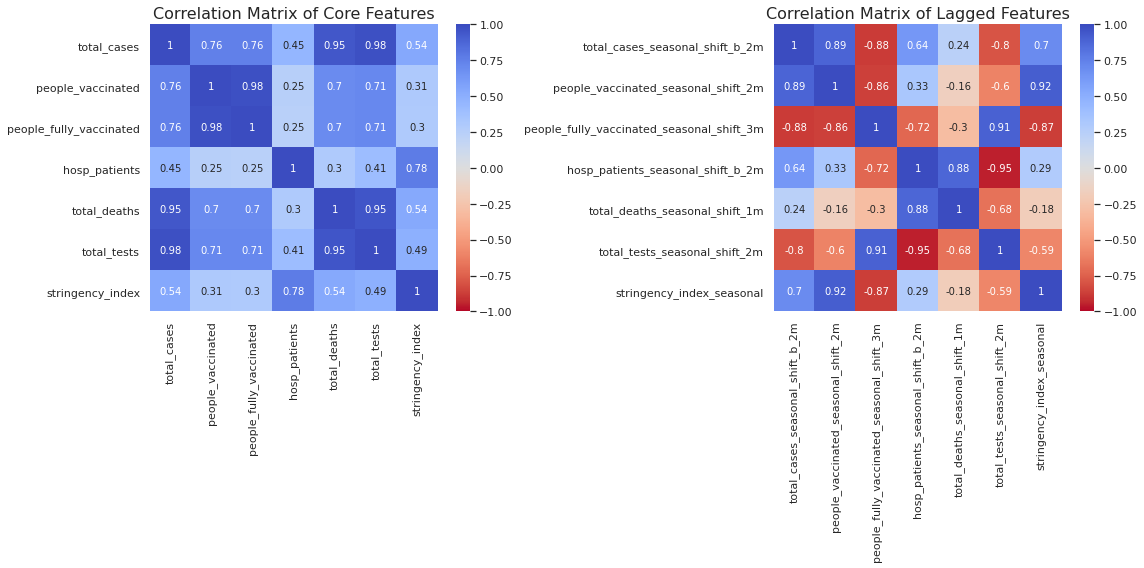

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corr_matrix = df_n[core_columns].corr()

sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

lagged_cols = [
    'total_cases_seasonal_shift_b_2m',
    'people_vaccinated_seasonal_shift_2m',
    'people_fully_vaccinated_seasonal_shift_3m',
    'hosp_patients_seasonal_shift_b_2m',
    'total_deaths_seasonal_shift_1m',
    'total_tests_seasonal_shift_2m',
    'stringency_index_seasonal'
]

corr_matrix = df_n[lagged_cols].corr()

sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)

fig.tight_layout()

As we can see, the features are higher correlated in the case of the original cases instead of the shifted ones. What is more important is that we can see that the `stringency_index` is correlated higher in the lagged matrix.
***

### <center>6.1 Autocorrelation Analysis</center>
<hr>
Now that we have stationarized by differencing the time-series, the next step is to determine whether AR (<b>autoregressive process</b>) or MA (<b>moving average</b>) terms are needed to correct any autocorrelation that persists in the differenced time-series. To achieve that, we will be looking into the <b>autocorrelation function (ACF)</b> and <b>partial autocorrelation (PACF)</b> plots of the differenced series. This way we can identify the numbers of the AR and/or MA terms.  
<ul>
    <li>
        <b>Autocorrelation Function (ACF)</b>: <i>P</i> = Periods to lag. For example: if <i>P=5</i> then we will use the five previous periods of our time series in the autoregressive portion of the calculation. <i>P</i> helps adjust the line that is being fitted to forecast the series. <i>P</i> corresponds with the MA parameter
    </li>
    <li>
        <b>Partial Autocorrelation Function (PACF)</b>: <i>D</i> = Order of difference. We have transformed the time series into stationary one(without trend or seasonality) using differencing. <i>D</i> corresponds with the AR parameter
    </li>
</ul>
<br>
The <i>autocorrelation plots</i> also help in detecting seasonality.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

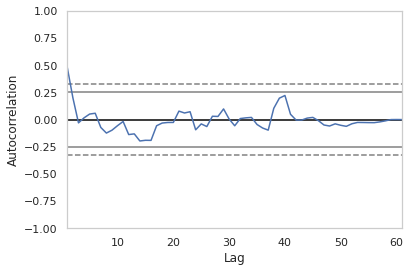

In [42]:
autocorrelation_plot(df_n['stringency_index_diff'])

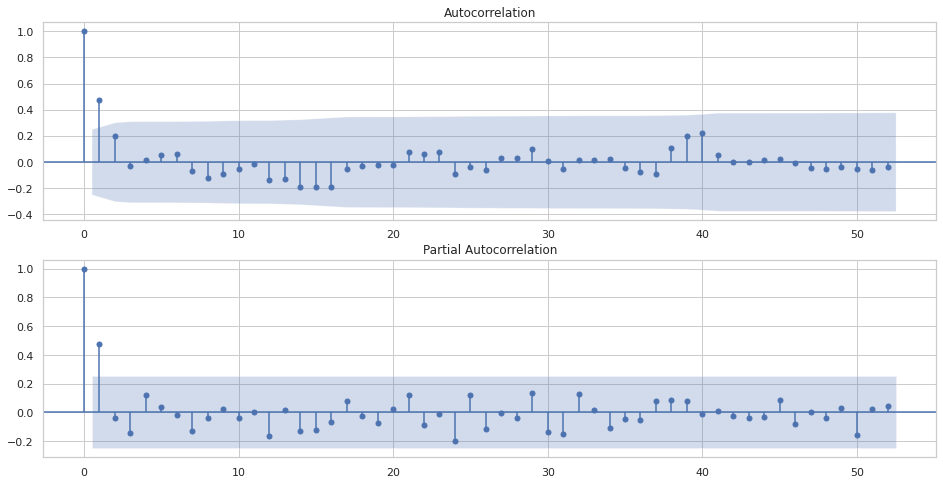

In [43]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

k = 52

plot_acf(df_n['stringency_index_diff'], lags=k, ax=ax[0]);
plot_pacf(df_n['stringency_index_diff'], lags=k, ax=ax[1], method='yw_mle');

## <center>7. Conclusion ✔</center>
<hr>
In this section, we will be storing the data and summarizing the process we undertook to clean and prepare it.

### 7.1 Data Storage 📁  
***  
We will be storing the data in the form of a `.csv` file. As we do not have an API the easiest way to provide the data will be in this format. For later stages there could be a public facing API, as well as a _DVC (data version control)_ solution to keep track of the changes in the data.

In [44]:
df_n.to_csv('./data/nl-data.csv', index=False)

### 7.2 Summary 📔  
***  
We have looked into the features of interest and performed a few integral operations to analyze it. We have differenced, rejected the null hypothesis by performing an ADF test (unit root test). Our target feature is the `stringency_index` and here are the findings:  
* We found that there could be a better pattern to follow if we downsample the data to smooth it  
* We found that we had to difference the data to 1st or 2nd order to stationarize some features  
* We found that overall, there is a higher correlation between the non-lagged features but as for the `stringency_index`, there are some points that are highly correlated after lagging them  
* We found that COVID-19 is not a seasonal phenomenon since we could not observe seasonality in our data  
***

## References:  
* Seasonality - <a href="https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc443.htm#:~:text=If%20there%20is%20significant%20seasonality,the%20further%20out%20we%20go).">https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc443.htm#:~:text=If%20there%20is%20significant%20seasonality,the%20further%20out%20we%20go).</a>  
* Scatter plot and checking for seasonality - <a href="https://www.itl.nist.gov/div898/handbook/eda/section3/scatterp.htm">https://www.itl.nist.gov/div898/handbook/eda/section3/scatterp.htm</a>  
* Time series decomposition - <a href="https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/#:~:text=Time%20series%20decomposition%20involves%20thinking,time%20series%20analysis%20and%20forecasting.">https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/#:~:text=Time%20series%20decomposition%20involves%20thinking,time%20series%20analysis%20and%20forecasting.</a>  
* Removing seasonality and trends in time series - <a href="https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/">https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/</a>  
* ARIMA - <a href="https://people.duke.edu/~rnau/411arim2.htm">https://people.duke.edu/~rnau/411arim2.htm</a>  
* ACF - <a href="https://medium.com/analytics-vidhya/interpreting-acf-or-auto-correlation-plot-d12e9051cd14#:~:text=successive%20time%20intervals.-,%3E,represents%20a%20perfect%20negative%20correlation.">https://medium.com/analytics-vidhya/interpreting-acf-or-auto-correlation-plot-d12e9051cd14#:~:text=successive%20time%20intervals.-,%3E,represents%20a%20perfect%20negative%20correlation.</a>  
* Autoregressive processes - <a href="https://www.investopedia.com/terms/a/autoregressive.asp">https://www.investopedia.com/terms/a/autoregressive.asp</a>  
* Moving windows and moving window calculations - <a href="https://towardsdatascience.com/dont-miss-out-on-rolling-window-functions-in-pandas-850b817131db">https://towardsdatascience.com/dont-miss-out-on-rolling-window-functions-in-pandas-850b817131db</a>  
* Rolling window analysis for time series - <a href="https://www.mathworks.com/help/econ/rolling-window-estimation-of-state-space-models.html">https://www.mathworks.com/help/econ/rolling-window-estimation-of-state-space-models.html</a>  
* ACF and PACF - <a href="https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8">https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8</a>  
* Detection of multicollinearity in regression analysis - <a href="https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/">https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/</a>  
* ARIMA vs Prophet for time series forecasting - <a href="https://medium.com/analytics-vidhya/time-series-forecasting-arima-vs-prophet-5015928e402a">https://medium.com/analytics-vidhya/time-series-forecasting-arima-vs-prophet-5015928e402a</a>  
* ARIMA models and demos - <a href="https://towardsdatascience.com/time-series-forecasting-arima-models-7f221e9eee06">https://towardsdatascience.com/time-series-forecasting-arima-models-7f221e9eee06</a>  
* Complete guide to time series forecasting - <a href="https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/">https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/</a>  